In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque
import random


num_of_episodes = 2000
learning_rate = 0.01
discount = .99
rList=[]
state_buffer = deque(maxlen=10000)

env = gym.make('FrozenLake-v0')

In [2]:
class DQN:
    
    def __init__(self, sess, size_in, size_out, name="main"):
        self.sess = sess
        self.size_in = size_in
        self.size_out = size_out
        self.name = name
        
        self.build_network()
    
    def build_network(self, h_size=32, learning_rate=0.01):
        with tf.variable_scope(self.name):
            self.X = tf.placeholder(tf.float32, [None, self.size_in])
            self.Y = tf.placeholder(tf.float32)
            self.A = tf.placeholder(tf.float32)

            layer1 = tf.layers.dense(self.X, h_size, activation=tf.nn.relu, )
            self.Qpred = tf.layers.dense(layer1, self.size_out)

            self.cost = tf.reduce_sum(tf.square(self.Y*self.A - self.Qpred*self.A))
            self.train = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(self.cost)
            
    def predict(self, state):
        return self.sess.run(self.Qpred, {self.X: np.reshape(state, [-1, self.size_in])})
                             
    def update(self, state_array, reward_array, action_array):
        return self.sess.run([self.cost,self.train], feed_dict={self.X:state_array, self.Y:reward_array, self.A:action_array})
    
def get_copy_var_ops(dest_scope_name, src_scope_name):

    op_holder = []

    src_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)

    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))

    return op_holder


In [3]:
def one_hot(x):
    return np.identity(16)[x:x+1]

def show_play(env, sess, DQN):
    state = env.reset()
    env.render()
    reward_all = 0
    while True:
        action = np.argmax(DQN.predict(one_hot(state)))
        state, reward, done, info = env.step(action)
        env.render()
        print("State: ", state, "Action: ", action,"Reward: ", reward, "Info: ", info)
        reward_all += reward
        if done:
            break
    return reward

Success rate: 0.596


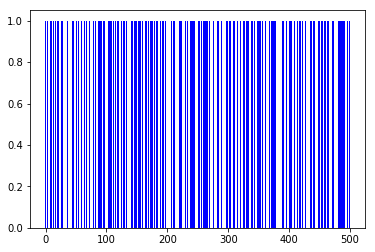


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 4, 'Action: ', 0, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 0, 'Action: ', 0, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 4, 'Action: ', 0, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 8, 'Action: ', 0, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Up)
SFFF
FHFH
FFFH
HFFG
('State: ', 4, 'Action: ', 3, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 0, 'Action: ', 0, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 0, 'Action: ', 0, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 0, 'Action: ', 0, 'Reward: ', 0.0, 'Info: ', {'prob': 0.3333333333333333})
  (Left)
SFFF
FHFH
FFFH
HFFG
('State: ', 0, 'Action: 

In [4]:
with tf.Session() as sess:
    mainDQN = DQN(sess, env.observation_space.n, env.action_space.n)
    targetDQN = DQN(sess, env.observation_space.n, env.action_space.n, "target")

    sess.run(tf.global_variables_initializer())
    
    copy_ops = get_copy_var_ops(dest_scope_name="target", src_scope_name="main")
    # copy from main to target
    sess.run(copy_ops)
    
    for step in range(num_of_episodes):

        s = env.reset()
        e = 1. / ((step / 10) + 1)
        rAll = 0
        done = False

        while not done:
            Qs = mainDQN.predict(one_hot(s))
            
            if np.random.rand(1) < e:
                a = env.action_space.sample()
            else:
                a = np.argmax(Qs)     
            
            s1, reward, done, info = env.step(a)
            
            if done:
                Qs[0,a] = reward
            else:
                Qs1 = targetDQN.predict(one_hot(s1))
                Qs[0,a] = reward + discount * np.max(Qs1)
                            
            state_buffer.append([s,Qs[0],a])
            
            if len(state_buffer) > 100:
                mini_batch = random.sample(state_buffer, 100)
                state_array = np.array([one_hot(x[0])[0] for x in mini_batch])
                reward_array = np.array([x[1] for x in mini_batch])
                action_array = np.array([np.identity(4)[x[2]] for x in mini_batch])
                
                mainDQN.update(state_array, reward_array, action_array)
            
            rAll += reward
            s = s1
        rList.append(rAll)
        
        if step % 5 == 0:
            sess.run(copy_ops)
            
    rList = rList[1500:]
    print("Success rate: " + str(sum(rList) / len(rList)))
    plt.bar(range(len(rList)), rList, color="blue")
    plt.show()
    
    show_play(env, sess, mainDQN)